In [1]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
os.chdir("/root/acdcpp/docstring_task/")
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['font.size'] = 50

device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


In [40]:
from acdc.docstring.utils import get_docstring_subgraph_true_edges

RUN_NAME = 'abs_edges'

# with open(f'acdc_edges_num_passes.json', 'r') as f:
#     num_passes = json.load(f)

with open(f'acdc_edges_acdc_scores.json', 'r') as f:
    acdc_scores = json.load(f)

with open(f'acdc_edges_acdcpp_scores.json', 'r') as f:
    acdcpp_scores = json.load(f)

acdc_scores = acdc_scores['-10']
acdcpp_scores = acdcpp_scores[list(acdcpp_scores.keys())[0]]

true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]').replace('None', ':')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{child_name}{replace_parens(child_idx)}{parent_name}{replace_parens(parent_idx)}')

for acdc_edge in set(acdc_scores.keys()) - set(acdcpp_scores.keys()):
    print("Missing!!!", acdc_edge)
    # acdcpp_scores[acdc_edge] = acdc_scores[acdc_edge]
    
for acdcpp_edge in set(acdcpp_scores.keys()) - set(acdc_scores.keys()):
    print("Missing:", acdcpp_edge)
    # acdc_scores[acdcpp_edge] = acdcpp_scores[acdcpp_edge]

# Attribution Scores Scatter Plot

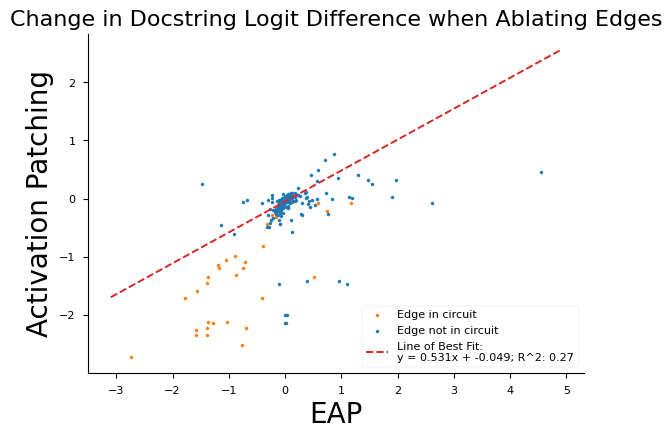

In [49]:
from sklearn.linear_model import LinearRegression
acdc_attrs = []
acdcpp_attrs = []
edge_names = []
is_in_circuit = []

assert sorted(set(acdcpp_scores.keys())) == sorted(set(acdc_scores.keys()))

for acdcpp_edge, acdc_edge in zip(sorted(acdcpp_scores.keys()), sorted(acdc_scores.keys())):
    assert acdcpp_edge == acdc_edge
    acdc_attrs.append(-acdc_scores[acdcpp_edge])
    acdcpp_attrs.append(acdcpp_scores[acdcpp_edge])
    edge_names.append(acdcpp_edge)

    if acdc_edge in true_edges:
        is_in_circuit.append(True)
    else:
        is_in_circuit.append(False)

# Finding line of best fit
linreg = LinearRegression()
linreg.fit(np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs)
slope = linreg.coef_
intercept = linreg.intercept_
r2 = linreg.score(np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs)
scatter_df = pd.DataFrame({'acdc_attrs': acdc_attrs, 'acdcpp_attrs': acdcpp_attrs, 'is_in_circuit': is_in_circuit})

ax = plt.gca()
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == True]['acdcpp_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == True]['acdc_attrs'],
    marker='o', s=5,c='#ff7f0e', label='Edge in circuit'
)
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == False]['acdcpp_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == False]['acdc_attrs'],
    marker='o', s=5,c='#1f77b4', label='Edge not in circuit'
)
x = np.linspace(*ax.get_xlim())
#ax.plot(x, x, linestyle='dashed', label='y = x', color='#2ca02c')
ax.plot(x, (slope * x) + intercept, linestyle='dashed', label=f'Line of Best Fit: \ny = {slope[0]:.3f}x + {intercept:.3f};\n R^2: {r2:.2f}', color='#d62728')
ax.set_ylabel('Activation Patching', size=20)
ax.set_xlabel('EAP', size=20)
ax.set_title('Change in Docstring Logit Difference when Ablating Edges', size=16)
ax.legend(loc='lower right', fontsize=8)
plt.savefig('Attrib_vs_Activ_Scores_Docstring.pdf')

In [42]:
linreg = LinearRegression()
linreg.fit(np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs)
slope = linreg.coef_
intercept = linreg.intercept_
print(f'y = {slope}x + {intercept}')

y = [0.53108226]x + -0.04899448395661489


In [34]:
import plotly.graph_objects as go

scatter_df = pd.DataFrame({
    'acdc_attrs': acdc_attrs, 
    'acdcpp_attrs': acdcpp_attrs, 
    'is_in_circuit': is_in_circuit,
    'edge_names': edge_names,
})

# Create a scatter plot
fig = go.Figure()

# Add these as labels later
names_of_edges_in_circuit = scatter_df[scatter_df['is_in_circuit'] == True]['edge_names'].values
names_of_edges_not_in_circuit = scatter_df[scatter_df['is_in_circuit'] == False]['edge_names'].values

# Add data for edges in circuit
fig.add_trace(go.Scatter(
    x=scatter_df[scatter_df['is_in_circuit'] == True]['acdcpp_attrs'],
    y=scatter_df[scatter_df['is_in_circuit'] == True]['acdc_attrs'],
    mode='markers',
    marker=dict(color='#ff7f0e'),
    name = 'Edge in circuit',
    text = names_of_edges_in_circuit,

))

# Add data for edges not in circuit
fig.add_trace(go.Scatter(
    x=scatter_df[scatter_df['is_in_circuit'] == False]['acdcpp_attrs'],
    y=scatter_df[scatter_df['is_in_circuit'] == False]['acdc_attrs'],
    mode='markers',
    marker=dict(color='#1f77b4'),
    name = 'Edge not in circuit',
    text = names_of_edges_not_in_circuit,
))

# Add line of best fit
x = np.linspace(min(acdcpp_attrs), max(acdcpp_attrs), 100)
fig.add_trace(go.Scatter(
    x=x,
    y=(slope * x) + intercept,
    mode='lines',
    line=dict(color='#d62728', dash='dash'),
    name=f'Line of Best Fit \ny = {slope[0]:.3f}x + {intercept:.3f}; R^2: {r2:.2f}'
))

# Update layout
fig.update_layout(
    title='Attribution vs Activation Patching Change in Metric (Docstring Circuit)',
    xaxis_title='Attribution Patching Change in Metric (Approximation)',
    yaxis_title='Activation Patching Change in Metric',
    legend_title="Legend"
)

# Show the plot
fig.show()


In [5]:
sum(scatter_df["acdcpp_attrs"].tolist())

-27.503746799386136

In [7]:
np.array(acdcpp_attrs).reshape(-1, 1), acdc_attrs

(array([[ 0.04641229],
        [ 1.41586459],
        [ 0.36093009],
        ...,
        [-0.00215145],
        [ 0.01526865],
        [ 0.01093859]]),
 [-0.04641228914260864,
  -1.4158645868301392,
  -0.36093008518218994,
  -0.022077977657318115,
  -0.012190461158752441,
  -1.9943292737007141,
  0.3193788528442383,
  0.03292405605316162,
  -0.05331993103027344,
  -1.4626652002334595,
  -0.4856427013874054,
  0.01406717300415039,
  -0.038145601749420166,
  -2.1287184357643127,
  0.2559630870819092,
  0.06338334083557129,
  -0.28475266695022583,
  -0.07084167003631592,
  -0.042633235454559326,
  -0.025608360767364502,
  -0.021474361419677734,
  -1.3456472754478455,
  -0.060746073722839355,
  -0.03389310836791992,
  -0.04641443490982056,
  -1.415867030620575,
  -0.3609355688095093,
  -0.022080302238464355,
  -0.012193024158477783,
  -1.9943385124206543,
  0.3193768262863159,
  0.032910943031311035,
  -0.053314208984375,
  -1.4626558423042297,
  -0.4856395274400711,
  0.01407402753829956

In [8]:
mpl.rcParams["axes.prop_cycle"]

'#1f77b4'
'#ff7f0e'
'#2ca02c'
'#d62728'
'#9467bd'
'#8c564b'
'#e377c2'
'#7f7f7f'
'#bcbd22'
'#17becf'


# ROC Curve

In [9]:
print(np.quantile(acdc_attrs, [0, .1, .25, .5, 0.75, .9, 1]))
print(np.quantile(acdcpp_attrs, [0, .1, .25, .5, 0.75, .9, 1]))

[-9.47713852e+00 -5.39084382e-02 -8.15692032e-03 -1.73929700e-04
  4.65663569e-03  2.76020212e-02  9.38177109e+00]
[-9.38177109e+00 -2.76020212e-02 -4.65663569e-03  1.73929700e-04
  8.15692032e-03  5.39084382e-02  9.47713852e+00]


In [10]:
for e, a in acdcpp_scores.items():
    if abs(a) >= 0.001:
        print(e)

blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 7]
blocks.3.hook_resid_post[:]blocks.0.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 2]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 1]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 3]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 6]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 0]
blocks.3.hook_resid_post[:]blocks.1.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 7]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 0]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 3]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 4]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 5]
blocks.3.hook_resid_post[:]blocks.3.attn.hook_result[:, :, 6]
blocks.3.hook_resid_post[:]blocks.2.attn.hook_result[:, :, 2]
blocks.3

In [11]:
def edges_after_thresh(thresh, scores, attr_abs=True):
    edges = set()
    for edge, attr in scores.items():
        #print(edge, abs(attr), thresh, abs(attr) >= thresh)
         # If attr < thresh, would've been removed
        if attr_abs:
            attr = abs(attr)
        if attr >= thresh:
            #print(edge)
            edges.add(edge)
    return edges

data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
    'TPR': [1],
    'TNR': [0],
    'FPR': [1],
    'FNR': [0],
}

# This should be the same as acdcpp_attrs_set, assert just in case
all_edges = set(acdcpp_scores.keys())

for thresh in np.logspace(-3, 1, num=50, base=5):
    data['Threshold'].append(float(thresh))
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_edges = edges_after_thresh(float(thresh), acdcpp_scores)
    edges = edges_after_thresh(float(thresh), acdc_scores)
    
    pp_tp = len(pp_edges.intersection(true_edges))
    pp_tn = len((all_edges - true_edges).intersection(all_edges - pp_edges))
    pp_fp = len(pp_edges - true_edges)
    pp_fn = len(true_edges - pp_edges)

    tp = len(edges.intersection(true_edges))
    tn = len((all_edges - true_edges).intersection(all_edges - edges))
    fp = len(edges - true_edges)
    fn = len(true_edges - edges)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

    data['TPR'].append(tpr)
    data['TNR'].append(tnr)
    data['FPR'].append(fpr)
    data['FNR'].append(fnr)
df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1, 0, 1, 0, 1]
df.loc[len(df)] = row

In [12]:
df.head(50)

,Threshold,ACDCpp TPR,ACDCpp TNR,ACDCpp FPR,ACDCpp FNR,TPR,TNR,FPR,FNR
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.008000,1.000000,0.555635,0.444365,0.000000,1.000000,0.555635,0.444365,0.000000
2,0.009123,1.000000,0.580164,0.419836,0.000000,1.000000,0.580164,0.419836,0.000000
3,0.010404,1.000000,0.600071,0.399929,0.000000,1.000000,0.600071,0.399929,0.000000
4,0.011865,1.000000,0.625311,0.374689,0.000000,1.000000,0.625311,0.374689,0.000000
5,0.013531,1.000000,0.649485,0.350515,0.000000,1.000000,0.649485,0.350515,0.000000
6,0.015431,1.000000,0.670459,0.329541,0.000000,1.000000,0.670459,0.329541,0.000000
7,0.017597,1.000000,0.689655,0.310345,0.000000,1.000000,0.689655,0.310345,0.000000
8,0.020068,1.000000,0.711340,0.288660,0.000000,1.000000,0.711340,0.288660,0.000000
9,0.022885,1.000000,0.735158,0.264842,0.000000,1.000000,0.735158,0.264842,0.000000


In [13]:
df['TPR']

0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    0.972973
17    0.972973
18    0.972973
19    0.945946
20    0.891892
21    0.891892
22    0.864865
23    0.837838
24    0.810811
25    0.783784
26    0.783784
27    0.756757
28    0.756757
29    0.756757
30    0.729730
31    0.675676
32    0.675676
33    0.648649
34    0.621622
35    0.594595
36    0.486486
37    0.432432
38    0.432432
39    0.324324
40    0.270270
41    0.135135
42    0.054054
43    0.027027
44    0.027027
45    0.027027
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
Name: TPR, dtype: float64

In [14]:
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-docstring_metric-False-0.json', 'r') as f:
    acdc_docstring_metric = json.load(f)
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-kl_div-False-0.json', 'r') as f:
    acdc_kl_metric = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-docstring_metric-False-0.json'

In [ ]:
acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC'].keys()

dict_keys(['test_docstring_stefan', 'score', 'test_docstring_metric', 'steps', 'test_kl_div', 'test_nll', 'test_match_nll', 'edge_fpr', 'edge_tpr', 'edge_precision', 'n_edges', 'node_fpr', 'node_tpr', 'node_precision', 'n_nodes'])

In [ ]:
# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc

from scipy import integrate

acdcpp_auc = round(abs(auc(df['ACDCpp FPR'], df['ACDCpp TPR'])), 3)
activ_auc = round(abs(auc(df['FPR'], df['TPR'])), 3)
acdc_docstring_auc = round(
    abs(
        integrate.trapz(
            acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
            acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr']
        )
    ), 3)
acdc_kl_auc = round(
    abs(
        integrate.trapz(
            acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_fpr'],
            acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_tpr']
        )
    ), 3)

plt.step(df['ACDCpp FPR'], df['ACDCpp TPR'], marker='.', label=f'EAP Only; (AUC = {acdcpp_auc})')
plt.step(df['FPR'], df['TPR'], marker='.', label=f'Activation Patching; (AUC = {activ_auc})')
plt.step(
    acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
    acdc_docstring_metric['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr'],
    marker='.', 
    label=f'ACDC w/ Docstring Metric; (AUC = {acdc_docstring_auc})'
)
plt.step(
    sorted(acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_fpr']),
    sorted(acdc_kl_metric['trained']['random_ablation']['docstring']['kl_div']['ACDC']['edge_tpr']),
    marker='.', 
    label=f'ACDC w/ KL Divergence metric; (AUC = {acdc_kl_auc})'
)
plt.xlabel('False Positive Rate', size=11)
plt.ylabel('True Positive Rate', size=11)
plt.title('Receiver Operator Characteristic Curve (Docstring Task)', size=11)
plt.legend()
plt.savefig('Docstring_ROC_Curve.pdf')

NameError: name 'acdc_docstring_metric' is not defined

In [ ]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC'].keys()

dict_keys(['steps', 'test_docstring_metric', 'score', 'test_kl_div', 'test_docstring_stefan', 'test_nll', 'test_match_nll', 'edge_fpr', 'edge_tpr', 'edge_precision', 'n_edges', 'node_fpr', 'node_tpr', 'node_precision', 'n_nodes'])

In [ ]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['test_nll']

[inf,
 6.28870964050293,
 5.1365556716918945,
 4.315356731414795,
 4.0975165367126465,
 2.9506542682647705,
 2.324460983276367,
 2.0739328861236572,
 1.8339952230453491,
 1.390416145324707,
 1.1645818948745728,
 1.0276647806167603,
 1.0224393606185913,
 1.0109184980392456,
 0.9042666554450989,
 1.0111387968063354,
 0.9957236647605896,
 1.0012856721878052,
 1.0057801008224487,
 1.0577392578125,
 1.0266523361206055,
 1.020729660987854,
 -inf]

In [ ]:
df['pp_Youdens_J'] = df['ACDCpp TPR'] - df['ACDCpp FPR']
df['Youdens_J'] = df['TPR'] - df['FPR']
best_threshold_pp = df.loc[df['pp_Youdens_J'].idxmax(), 'Threshold']
best_threshold = df.loc[df['Youdens_J'].idxmax(), 'Threshold']
print(best_threshold_pp, best_threshold)

0.0473844 0.1688318


In [ ]:
scores_data = {'attr': [], 'is_in_circuit': []}
for edge, attr in acdcpp_scores.items():
    scores_data['attr'].append(attr)
    if edge in true_edges:
        scores_data['is_in_circuit'].append(True)
    else:
        scores_data['is_in_circuit'].append(False)
        
scores_df = pd.DataFrame(scores_data)

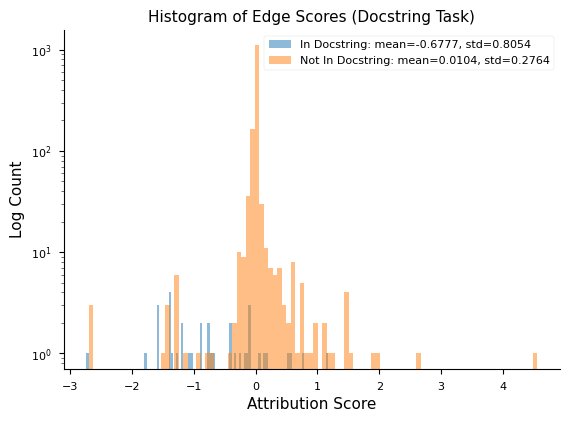

In [ ]:
fig, ax = plt.subplots()

# Calculate the mean and standard deviation of scores for positive and negative cases
positive_scores = scores_df[scores_df['is_in_circuit'] == True]['attr']
negative_scores = scores_df[scores_df['is_in_circuit'] == False]['attr']

positive_mean = np.mean(positive_scores)
positive_std = np.std(positive_scores)

negative_mean = np.mean(negative_scores)
negative_std = np.std(negative_scores)


# Plot the distribution of scores for positive and negative cases
ax.hist(positive_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'In Docstring: mean={positive_mean:.4f}, std={positive_std:.4f}')
ax.hist(negative_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'Not In Docstring: mean={negative_mean:.4f}, std={negative_std:.4f}')

# Set the title and labels
ax.set_title('Histogram of Edge Scores (Docstring Task)', size=11)
ax.set_xlabel('Attribution Score', size=11)
ax.set_ylabel('Log Count', size=11)

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.show()
fig.savefig('Docstring_Hist_Scores.pdf')